## Preproceso de datos

### Estandarizar variables

Vamos a cargar un conjunto de datos de ventas de casas en King County, USA ([fuente](https://www.kaggle.com/harlfoxem/housesalesprediction))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

house = pd.read_csv('../../data/kc_house_data.csv')

In [2]:
house['id'].unique().size

21436

In [3]:
house.shape

(21613, 21)

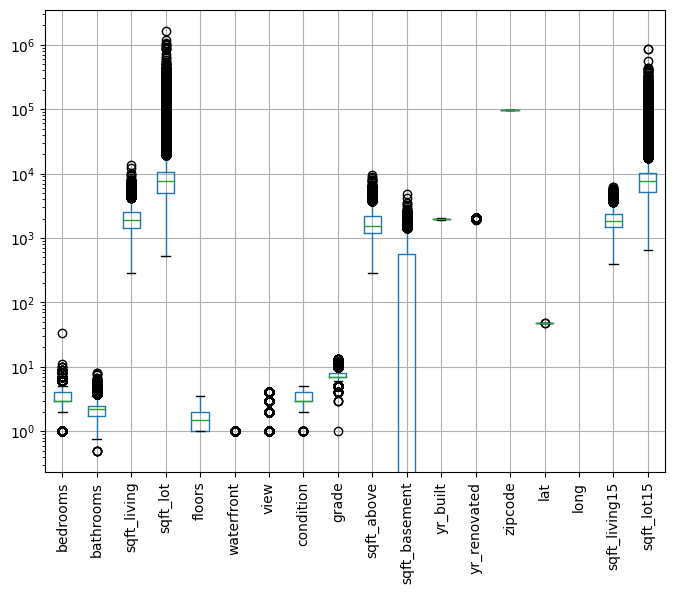

In [4]:
house.drop(columns=['id', 'date', 'price']).boxplot(figsize=(8, 6))
plt.yscale('log')
plt.xticks(rotation=90);

In [5]:
colnames = house.columns.difference(['id', 'date', 'price'])
ncol = 5
nrow = len(colnames) // ncol

In [6]:
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for idx, (ax, col) in enumerate(zip(axes.ravel(), colnames)):
    ax.scatter(house[col], house['price'])
    if idx % ncol != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_title(col)
fig.tight_layout(h_pad=1)

Muchos modelos de aprendizaje automático requieren que todas las variables tengan rangos similares. De lo contrario unas van a dominar las función objetivo que se optimiza, haciendo que el modelo no aprenda del resto. Un ejemplo son los modelos basados en distancias, como $k$ vecinos próximos. 

La clase `StandardScaler` estandariza cada columna para que tenga media 0 y desviación 1. Todas las funciones de preproceso cuentan con la siguiente API:

   * `fit()`, "ajusta" el modelo
   * `transform()`, realiza la transformación sobre nuevos datos, sin ajustar el modelo
   * `fit_transform()`, realiza ambas operaciones

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = house.drop(columns=['id', 'date', 'price'])
y = house['price']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.mean(axis=0)

array([-1.20549850e-16, -7.89053566e-17,  7.14531840e-17, -1.40276189e-17,
       -7.45217256e-18, -2.76168748e-17, -2.87127825e-17, -1.05645505e-16,
       -2.57757498e-16, -4.05485860e-17,  5.59460896e-17,  6.08447972e-16,
        3.50690474e-18, -7.08657774e-14, -4.13113378e-15,  1.68682118e-15,
       -1.02138600e-16, -1.22741666e-17])

In [10]:
X_test_scaled.mean(axis=0)

array([-0.0019043 , -0.01610966,  0.00508094, -0.00170434,  0.00585777,
       -0.03203456, -0.00485447,  0.01265919,  0.00760394, -0.00035065,
        0.01122545, -0.00503873,  0.00171003,  0.00689319,  0.00665717,
       -0.00148847, -0.02266669, -0.01135255])

En este caso "ajustar" el modelo consiste en calcular la media y la desviación de cada una de las columnas. Con `transform` usamos esas medias y desviaciones calculadas para estandarizar los datos, con la siguiente fórmula:

$$\text{col_std} = \frac{\text{col} - \text{media}}{\text{desv}}$$

Es **muy importante** no usar la función `fit_transform` a la hora de escalar los datos de test, ya que cuando el modelo esté en producción no se va a poder calcular para nuevos datos. Por tanto, hay que hacer la transformación con las medias y desviaciones de los datos de entrenamiento con la función `transform`. Podemos ver estas medias y desviaciones que ha calculado el modelo:

In [11]:
scaler.mean_

array([ 3.37127522e+00,  2.11786662e+00,  2.07873256e+03,  1.51242188e+04,
        1.49352212e+00,  8.26701215e-03,  2.35239682e-01,  3.40736628e+00,
        7.65463631e+00,  1.78846332e+03,  2.90269233e+02,  1.97104220e+03,
        8.42306743e+01,  9.80778478e+04,  4.75598225e+01, -1.22213844e+02,
        1.99044716e+03,  1.28477440e+04])

In [12]:
scaler.scale_

array([9.10643589e-01, 7.71925523e-01, 9.18742761e+02, 4.04822255e+04,
       5.37238147e-01, 9.05465000e-02, 7.71349478e-01, 6.51841475e-01,
       1.17652439e+00, 8.28435755e+02, 4.41724779e+02, 2.94184058e+01,
       4.01301975e+02, 5.33810514e+01, 1.38189367e-01, 1.40377395e-01,
       6.87198067e+02, 2.79328757e+04])

Vamos a ver la diferencia de rendimiento del modelo $k$ vecinos proximos con y sin estandarizar las variables:

In [13]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5295199151072938

In [14]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.80697324266706

### Otras formas de estandarizar

   * `preprocessing.MinMaxScaler`, escala los datos al intervalo $[0, 1]$
   * `preprocessing.RobustScaler`, escala los datos restando la mediana y dividiendo por el rango entre el primer y tercer cuartiles. Este escalado es más robusto cuando hay valores extremos.
   * `preprocessing.MaxAbsScaler`, escala los datos dividiendo por el máximo valor absoluto. Este escalado no resta la media, y por tanto mantiene los la dispersión de los datos originales (número de 0).

### Variables categóricas

Variables con un número de valores:

   1. discreto
   2. pequeño
   3. conocido
   
La mayoría de modelos no soportan este tipo de variables directamente, ya que requieren una matriz $X$ numérica. Por tanto, siempre que esten presentes tenemos que convertirlas en columnas numéricas.

In [15]:
import seaborn as sns

diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [16]:
diamonds['color'].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

Como ya vimos, una opción (en general mala) es transformarlas asignando un código numérico a cada categoría:

In [17]:
diamonds['color_ord'] = diamonds['color'].astype('category').cat.codes
diamonds[['color', 'color_ord']].head()

,color,color_ord
0,E,1
1,E,1
2,E,1
3,I,5
4,J,6


In [18]:
pd.Series(diamonds['color'].astype('category').cat.categories)

0    D
1    E
2    F
3    G
4    H
5    I
6    J
dtype: object

Esto es problemático porque:

   1. introduce un orden (generalmente artificial) entre los valores
   2. introduce distancias entre los valores
   
Por ejemplo en el caso de los datos de diamantes el valor "I" está a 1 unidad de distancia de "J" pero a 4 unidades de "E". Sin embargo para otro tipo de variables como "cut", que representan niveles crecientes del corte del diamante, si podría tener sentido esta codificación.

### Codificación *dummy* o *one-hot*

Crea tantas variables binarias (valores 0 o 1) como el número de categorías. Se pueden generar con `pd.get_dummies`:

In [19]:
color_dummy = pd.get_dummies(diamonds['color'])

In [20]:
df = pd.concat((diamonds[['color', 'color_ord']], color_dummy), axis=1)

In [21]:
def highlight_not_zero(s):
    not_zero = s != 0
    return ['background-color: yellow' if v else '' for v in not_zero]
    
df.head(10).style.apply(highlight_not_zero, subset=['D', 'E', 'F', 'G', 'H', 'I', 'J'])

,color,color_ord,D,E,F,G,H,I,J
0,E,1,0,1,0,0,0,0,0
1,E,1,0,1,0,0,0,0,0
2,E,1,0,1,0,0,0,0,0
3,I,5,0,0,0,0,0,1,0
4,J,6,0,0,0,0,0,0,1
5,J,6,0,0,0,0,0,0,1
6,I,5,0,0,0,0,0,1,0
7,H,4,0,0,0,0,1,0,0
8,E,1,0,1,0,0,0,0,0
9,H,4,0,0,0,0,1,0,0


Esta codificación es redundante en el sentido de que una de las columnas queda determinada por completo a partir de las otras. Por ejemplo, la columna J solo tiene valor* uno cuando el resto de columnas tienen **todas** valor 0. Esto puede empeorar el rendimiento de modelos que tienen problemas con variables muy correladas.

La función `get_dummies` tiene un parámetro que elimina automáticamente una de estas columnas (la primera). En general no es importante cual se elimine, pero a veces si relevante para interpretar el modelo resultante.

In [22]:
pd.get_dummies(diamonds['color'], drop_first=True).head()

,E,F,G,H,I,J
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


### Variables categóricas en scikit-learn

Las dos ténicas anteriores están implementadas en el módulo `preprocessing` de scikit-learn:

   1. `preprocessing.OneHotEncoder`: codificación dummy o one-hot
   2. `preprocessing.OrdinalEncoder`: codificación ordinal

In [23]:
from sklearn.preprocessing import OneHotEncoder

diamonds = sns.load_dataset('diamonds')

encoder = OneHotEncoder()
X = encoder.fit_transform(diamonds)

In [24]:
X

<53940x13687 sparse matrix of type '<class 'numpy.float64'>'
	with 539400 stored elements in Compressed Sparse Row format>

**Ojo**: la clase `OneHotEncoder` aplica sobre **todas** las columnas. 

Para realizar una operación sobre unas columnas y no otras tenemos que usar la clase `sklearn.compose.ColumnTransformer`, que permite aplicar distintas transformaciones a distintas columnas/grupos de columnas:

<img src=https://amueller.github.io/ml-workshop-1-of-4/slides/images/column_transformer_schematic.png width=600>

In [25]:
diamonds['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [27]:
diamonds.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

cat_order = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
]

col_trans = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include='number')),
    (OneHotEncoder(drop='first'), ['color', 'clarity']),
    (OrdinalEncoder(categories=cat_order), ['cut'])
)

In [30]:
diamonds["color"].nunique()

7

In [31]:
diamonds["clarity"].nunique()

8

In [28]:
diamonds.shape

(53940, 10)

In [34]:
X = col_trans.fit_transform(diamonds)
X.shape

(53940, 21)

In [55]:
col_trans.transformers_

[('standardscaler',
  StandardScaler(),
  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']),
 ('onehotencoder', OneHotEncoder(drop='first'), ['color', 'clarity']),
 ('ordinalencoder',
  OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']]),
  ['cut'])]

In [58]:
diamonds["color"].replace({"E": "D", "I": "K"})

0        D
1        D
2        D
3        K
4        J
        ..
53935    D
53936    D
53937    D
53938    H
53939    D
Name: color, Length: 53940, dtype: category
Categories (6, object): ['D', 'F', 'G', 'H', 'K', 'J']

In [61]:
d = pd.DataFrame({"tipo": ["rueda_coche", "rueda_coche", "rueda_camion", "volante_coche", "volante_coche"]})

In [63]:
d["tipo"].str.split("_", expand=True)

,0,1
0,rueda,coche
1,rueda,coche
2,rueda,camion
3,volante,coche
4,volante,coche


In [65]:
d["tipo"].map(lambda x: x[0])

0    r
1    r
2    r
3    v
4    v
Name: tipo, dtype: object

In [42]:
col_trans.transformers_[1][2]

['color', 'clarity']

In [50]:
onehot_names = []
for idx, var in enumerate(col_trans.transformers_[1][2]):
    for value in col_trans.transformers_[1][1].categories_[idx][1:]:
        onehot_names.append(str(var) + "_" + str(value))

In [51]:
new_names = col_trans.transformers_[0][2] + onehot_names + col_trans.transformers_[2][2]

In [53]:
pd.DataFrame(X, columns=new_names)

,carat,depth,table,price,x,y,z,color_E,color_F,color_G,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,cut
0,-1.198168,-0.174092,-1.099672,-0.904095,-1.587837,-1.536196,-1.571129,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
1,-1.240361,-1.360738,1.585529,-0.904095,-1.641325,-1.658774,-1.741175,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,-1.198168,-3.385019,3.375663,-0.903844,-1.498691,-1.457395,-1.741175,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.071587,0.454133,0.242928,-0.902090,-1.364971,-1.317305,-1.287720,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
4,-1.029394,1.082358,0.242928,-0.901839,-1.240167,-1.212238,-1.117674,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,-0.164427,-0.662711,-0.204605,-0.294731,0.016798,0.022304,-0.054888,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
53936,-0.164427,0.942753,-1.099672,-0.294731,-0.036690,0.013548,0.100988,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53937,-0.206621,0.733344,1.137995,-0.294731,-0.063434,-0.047741,0.030135,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
53938,0.130927,-0.523105,0.242928,-0.294731,0.373383,0.337506,0.285204,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0


In [54]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [30]:
diamonds.shape

(53940, 10)

In [31]:
diamonds.describe(exclude='number')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


¿Por qué el resultado tiene 23 columnas?

#### Modelos que soportan variables categóricas

Teóricamente, todos los modelos basados en árboles y naive Bayes soportan variables categóricas sin necesidad de transformarlas a variables continuas. Sin embargo, por motivos de eficiencia no es común implementarlos de esta forma. 

Actualmente en scikit-learn solo soportan variables categóricas directamente los modelos naive Bayes.

Se prevé que en próximas versiones los árboles de decisión, *random forest* y *gradient boosting* soporten variables discretas. Otras implementaciones no incluidas en scikit-learn (las veremos más adelantes si las soportan), como por ejemplo CatBoost, si cuentan con este soporte. 

In [ ]:
%pip install seaborn

### Ejercicios

#### Ejercicio 1

Con los datos del conjunto de datos de iris: 

   * Cargar los datos usando `sklearn.dataset.load_iris`
   * Separar en train-test
   * Ajustar un modelo de $k$ vecinos próximos sobre los datos estandarizados y sin estandarizar. ¿Cuál es la diferencia de rendimiento?


#### Ejercicio 2

Vamos a trabajar ahora con datos de propinas, que vienen incluidos en la librería `seaborn`. El nombre del conjunto de datos es `tips`, y contiene información sobre distintas variables que pueden tener influencia en las propinas:

   * Cargar el conjunto de datos
   
   * Ver el tipo de cada una de las columnas
   
   * Hacer alguna visualización para ver como se relacionan el resto de variables con la columna `tip` (por ejemplo usando las funciones `sns.pairplot` y `sns.catplot`)
   
   * De las columnas categóricas, ¿qué codificación tiene sentido usar para cada una de ellas?
   
   * Estandarizar las columnas numéricas y realizar la transformación correspondiente para cada una de las variables categóricas

In [67]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
iris.data.plot(kind='box');

In [71]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)

In [72]:
X_train.shape

(112, 4)

In [73]:
X_test.shape

(38, 4)

In [74]:
iris.data.shape

(150, 4)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_sc, y_train)
model.score(X_test_sc, y_test)

0.9210526315789473

In [84]:
y_train.nunique()

3

In [83]:
model.coef_

array([[-0.44600571,  0.79456379, -2.31508501, -0.92455311],
       [ 0.42766235, -0.53455119, -0.12515498, -0.93817324],
       [ 0.01834335, -0.2600126 ,  2.44023999,  1.86272635]])

In [88]:
import seaborn as sns

tips = sns.load_dataset('tips')
sns.pairplot(tips);

In [34]:
#%pip install scikit-learn==0.23.1
# Es posible que sea necesario reiniciar el kernel

import sklearn
sklearn.__version__

'0.24.2'

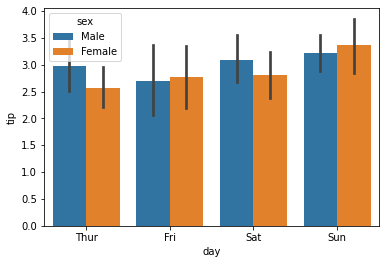

In [35]:
sns.barplot(x='day', y='tip', hue='sex', data=tips);

In [89]:
tips.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [95]:
cat = [
    ['Male', 'Female'],
    ['No', 'Yes'],
    ['Thur', 'Fri', 'Sat', 'Sun'], 
    ['Lunch', 'Dinner']
]

col_trans = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include='number')),
    (OneHotEncoder(categories=cat), make_column_selector(dtype_exclude='number'))
)

X = col_trans.fit_transform(tips)

In [96]:
X.shape

(244, 13)

In [93]:
import pandas as pd
pd.DataFrame(
    X, 
    columns=['total_bill', 'tip', 'size', 'sex_Female', 'smoker_Yes', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Dinner']
)

,total_bill,tip,size,sex_Female,smoker_Yes,day_Fri,day_Sat,day_Sun,time_Dinner
0,-0.314711,-1.439947,-0.600193,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.063235,-0.969205,0.453383,0.0,0.0,0.0,0.0,1.0,1.0
2,0.137780,0.363356,0.453383,0.0,0.0,0.0,0.0,1.0,1.0
3,0.438315,0.225754,-0.600193,0.0,0.0,0.0,0.0,1.0,1.0
4,0.540745,0.443020,1.506958,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
239,1.040511,2.115963,0.453383,0.0,0.0,0.0,1.0,0.0,1.0
240,0.832275,-0.722971,-0.600193,1.0,1.0,0.0,1.0,0.0,1.0
241,0.324630,-0.722971,-0.600193,0.0,1.0,0.0,1.0,0.0,1.0
242,-0.221287,-0.904026,-0.600193,0.0,0.0,0.0,1.0,0.0,1.0


In [40]:
3 + 3 + 3

9